## Importing necessary packages

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
from datetime import date
import seaborn as sns
from pydataset import data
from env import host, user, password
import os
from sklearn.feature_selection import SelectKBest, f_regression
import sklearn.preprocessing
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LassoLars
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures
import warnings
warnings.filterwarnings("ignore")

## Acquiring data

In [2]:
def get_zillow_data(host = host, user = user, password = password):
    filename = 'zillow.csv'
    if os.path.isfile(filename):
        return pd.read_csv(filename)
    else:
        db = 'zillow'
        df = pd.read_sql('SELECT taxamount, lotsizesquarefeet, yearbuilt, fips, taxvaluedollarcnt, calculatedfinishedsquarefeet, bathroomcnt, bedroomcnt, propertylandusetypeid, transactiondate FROM properties_2017 JOIN predictions_2017 USING(id) WHERE  propertylandusetypeid IN (261, 262, 263, 273, 275, 276, 279) AND transactiondate >= \'2017-05-01\' AND transactiondate <= \'2017-08-31\'', f'mysql+pymysql://{user}:{password}@{host}/{db}')
        df.to_csv(filename, index = False)
        return df


In [3]:
zillow = get_zillow_data()

## Prepping the data

In [4]:
zillow['age'] = 2021 - zillow.yearbuilt
zillow.drop(columns = ['propertylandusetypeid', 'transactiondate', 'yearbuilt'], inplace = True)
zillow.fips.replace({6037: 'Los Angeles', 6059: 'Orange', 6111: 'Ventura'}, inplace = True)
zillow.rename(columns = {'fips': 'county'}, inplace = True)
zillow['tax_rate'] = zillow.taxamount / zillow.taxvaluedollarcnt

In [5]:
zillow.dropna(inplace = True)

In [6]:
zillow.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30373 entries, 0 to 31208
Data columns (total 9 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   taxamount                     30373 non-null  float64
 1   lotsizesquarefeet             30373 non-null  float64
 2   county                        30373 non-null  object 
 3   taxvaluedollarcnt             30373 non-null  float64
 4   calculatedfinishedsquarefeet  30373 non-null  float64
 5   bathroomcnt                   30373 non-null  float64
 6   bedroomcnt                    30373 non-null  float64
 7   age                           30373 non-null  float64
 8   tax_rate                      30373 non-null  float64
dtypes: float64(8), object(1)
memory usage: 2.3+ MB


In [7]:
Q1 = zillow['taxvaluedollarcnt'].quantile(0.25)
Q3 = zillow['taxvaluedollarcnt'].quantile(0.75)
IQR = Q3 - Q1

zillow[zillow.taxvaluedollarcnt > (Q3 + IQR)].count()

taxamount                       2748
lotsizesquarefeet               2748
county                          2748
taxvaluedollarcnt               2748
calculatedfinishedsquarefeet    2748
bathroomcnt                     2748
bedroomcnt                      2748
age                             2748
tax_rate                        2748
dtype: int64

In [8]:
zillow_no_out = zillow[(zillow.taxvaluedollarcnt < (Q3 + IQR)) & (zillow.taxvaluedollarcnt > (Q1 - IQR))]

In [9]:
Q1 = zillow_no_out['tax_rate'].quantile(0.25)
Q3 = zillow_no_out['tax_rate'].quantile(0.75)
IQR = Q3 - Q1

zillow_no_out[zillow_no_out.tax_rate > (Q3 + IQR)].count()

taxamount                       3609
lotsizesquarefeet               3609
county                          3609
taxvaluedollarcnt               3609
calculatedfinishedsquarefeet    3609
bathroomcnt                     3609
bedroomcnt                      3609
age                             3609
tax_rate                        3609
dtype: int64

In [10]:
zillow_no_out = zillow_no_out[(zillow_no_out.tax_rate < (Q3 + IQR)) & (zillow_no_out.tax_rate > (Q1 - IQR))]

In [11]:
train, test = train_test_split(zillow_no_out, test_size=.2, random_state=123)
train, validate = train_test_split(train, test_size=.3, random_state=123)

## Explore

In [12]:
train

,taxamount,lotsizesquarefeet,county,taxvaluedollarcnt,calculatedfinishedsquarefeet,bathroomcnt,bedroomcnt,age,tax_rate
18348,4518.78,6000.0,Orange,367859.0,1835.0,2.0,4.0,56.0,0.012284
2686,9712.34,7208.0,Los Angeles,804692.0,1568.0,2.0,3.0,113.0,0.012070
18665,2309.76,5400.0,Orange,156287.0,2344.0,3.5,5.0,67.0,0.014779
27732,5292.13,7908.0,Los Angeles,441608.0,1440.0,2.0,3.0,68.0,0.011984
6221,2289.69,6089.0,Los Angeles,172918.0,1119.0,1.0,3.0,67.0,0.013241
...,...,...,...,...,...,...,...,...,...
24717,1025.35,4799.0,Los Angeles,80397.0,909.0,2.0,3.0,66.0,0.012754
15912,1552.52,5775.0,Los Angeles,119756.0,1704.0,2.0,4.0,57.0,0.012964
27453,4194.55,6157.0,Los Angeles,317331.0,1689.0,2.0,4.0,63.0,0.013218
14939,5508.96,6584.0,Los Angeles,399000.0,1585.0,1.0,3.0,80.0,0.013807


In [13]:
train.groupby('county').count()

,taxamount,lotsizesquarefeet,taxvaluedollarcnt,calculatedfinishedsquarefeet,bathroomcnt,bedroomcnt,age,tax_rate
county,,,,,,,,
Los Angeles,8926,8926,8926,8926,8926,8926,8926,8926
Orange,3524,3524,3524,3524,3524,3524,3524,3524
Ventura,784,784,784,784,784,784,784,784


<AxesSubplot:>

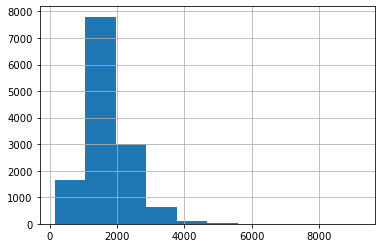

In [14]:
train.calculatedfinishedsquarefeet.hist()

<AxesSubplot:>

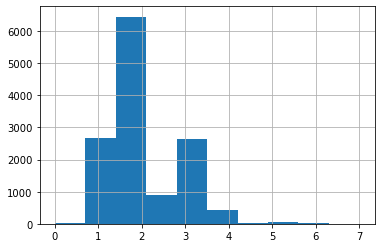

In [15]:
train.bathroomcnt.hist()

<AxesSubplot:>

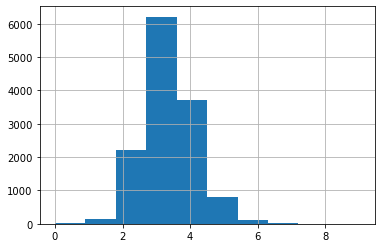

In [16]:
train.bedroomcnt.hist()

<AxesSubplot:>

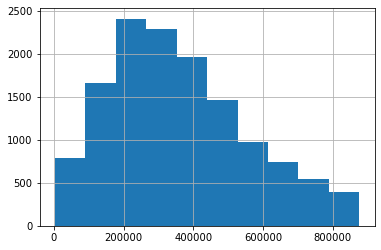

In [17]:
train.taxvaluedollarcnt.hist()

<AxesSubplot:xlabel='taxvaluedollarcnt'>

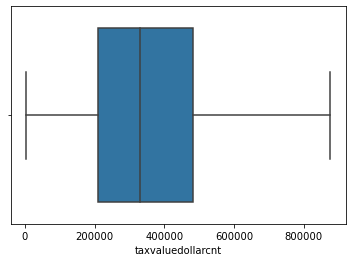

In [18]:
sns.boxplot(train.taxvaluedollarcnt)

<AxesSubplot:xlabel='bedroomcnt'>

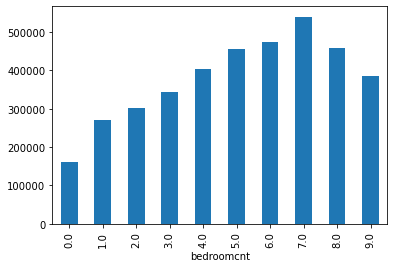

In [19]:
train.groupby('bedroomcnt').taxvaluedollarcnt.mean().plot.bar()

<AxesSubplot:xlabel='bathroomcnt'>

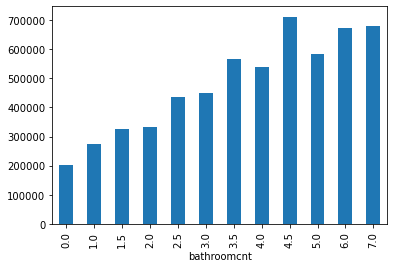

In [20]:
train.groupby('bathroomcnt').taxvaluedollarcnt.mean().plot.bar()

<AxesSubplot:xlabel='calculatedfinishedsquarefeet', ylabel='taxvaluedollarcnt'>

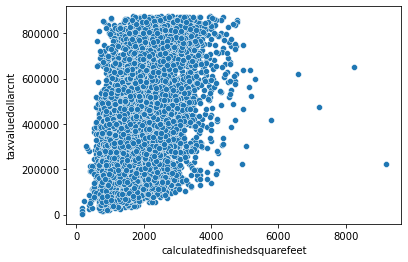

In [21]:
sns.scatterplot(x = 'calculatedfinishedsquarefeet', y = 'taxvaluedollarcnt', data = train)

<AxesSubplot:xlabel='age', ylabel='taxvaluedollarcnt'>

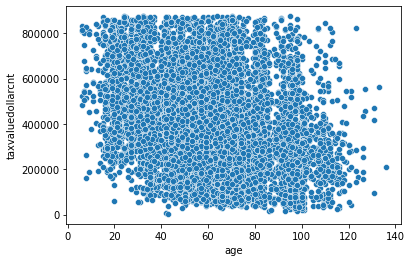

In [22]:
sns.scatterplot(x = 'age', y = 'taxvaluedollarcnt', data = train)

<AxesSubplot:xlabel='taxvaluedollarcnt', ylabel='Count'>

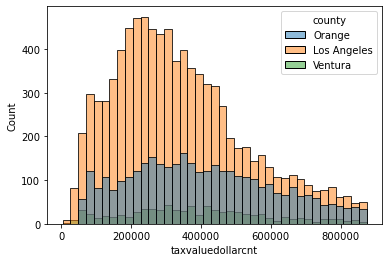

In [23]:
sns.histplot(data = train, x = "taxvaluedollarcnt", hue = "county")

<AxesSubplot:xlabel='county'>

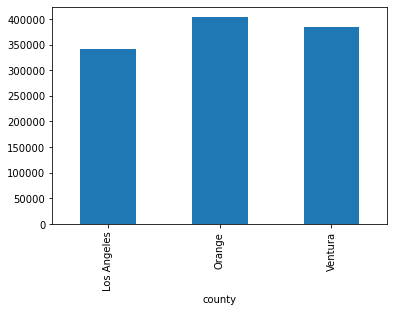

In [24]:
train.groupby('county').taxvaluedollarcnt.mean().plot.bar()

<AxesSubplot:xlabel='tax_rate', ylabel='Count'>

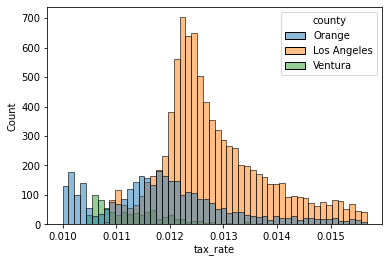

In [25]:
sns.histplot(data = train, x = "tax_rate", hue = "county")

<AxesSubplot:xlabel='county'>

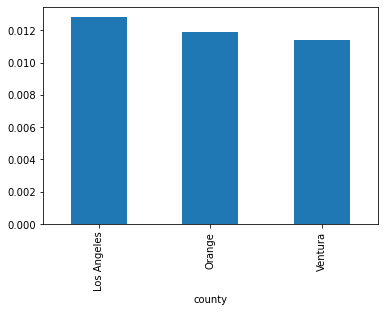

In [26]:
train.groupby('county').tax_rate.mean().plot.bar()

In [27]:
la_county = train[train['county'] == 'Los Angeles']
o_county = train[train['county'] == 'Orange']
vt_county = train[train['county'] == 'Ventura']
la_county.tax_rate.mean(), o_county.tax_rate.mean(), vt_county.tax_rate.mean()

(0.012822207434431916, 0.011910892984059708, 0.01141674697027671)

## Statistical tests

### Hypothesis 1

#### Null Hypothesis: There is no linear correlation between the square feet of a property and the tax value of that property

#### Alternative Hypothesis: There is a linear correlation between the square feet of a property and the tax value of that property

In [28]:
corr, p = stats.pearsonr(train.taxvaluedollarcnt, train.calculatedfinishedsquarefeet)
corr, p

(0.42606712089067234, 0.0)

#### We reject the null hypothesis that there is no linear relationship between square feet of a property and the tax value of that property.

A bigger house correlating with a higher value doesn't come as much of a surprise.

### Hypothesis 2

#### Null Hypothesis: There is no difference between Los Angeles county tax rate and the overall average county tax rates

#### Alternative Hypothesis:  There is a difference between Los Angeles county tax rate and the overall average county tax rates

<AxesSubplot:xlabel='tax_rate', ylabel='Density'>

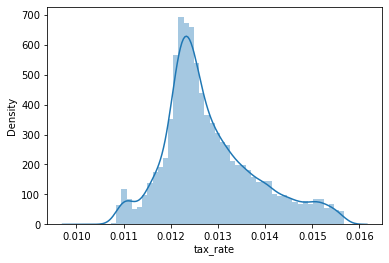

In [29]:
sns.distplot(train[train['county'] == 'Los Angeles'].tax_rate)

In [30]:
train.tax_rate.median(), train.tax_rate.mean()

(0.012381896759654933, 0.012496277773935494)

In [31]:
t, p = stats.ttest_1samp(la_county.tax_rate, zillow_no_out.tax_rate.mean())
t, p

(31.771943432031943, 5.706184280953346e-210)

#### We reject the null hypothesis that there is no difference between Los Angeles county tax rate and the overall average county tax rates

As could have been guessed by the tax rate histogram, it seems the tax rate in Los Angeles is higher than the average tax rate.

## Modeling

### Prepping again for modeling

In [32]:
zillow_no_out.drop(columns = ['tax_rate', 'bathroomcnt', 'taxamount'], inplace = True)
dummies_county = pd.get_dummies(zillow_no_out[['county']], drop_first = True)
zillow_no_out.drop(columns = ['county'], inplace = True)
zillow_no_out = pd.concat([zillow_no_out, dummies_county], axis=1)

In [33]:
scaler_minmax = sklearn.preprocessing.MinMaxScaler()
scaler_minmax.fit(zillow_no_out)
zillow_minmax = scaler_minmax.transform(zillow_no_out)
zillow_minmax = pd.DataFrame(zillow_minmax)
key = zillow_no_out.columns.tolist()
zillow_minmax.rename(columns = {i: key[i] for i in range(len(key))} , inplace = True)
zillow_minmax.drop(columns = ['taxvaluedollarcnt'], inplace = True)
zillow_no_out.index = zillow_minmax.index
zillow_minmax['taxvaluedollarcnt'] = zillow['taxvaluedollarcnt']
zillow_minmax.dropna(inplace = True)

In [34]:
train, test = train_test_split(zillow_minmax, test_size=.2, random_state=123)
train, validate = train_test_split(train, test_size=.3, random_state=123)

In [35]:
train.head()

,lotsizesquarefeet,calculatedfinishedsquarefeet,bedroomcnt,age,county_Orange,county_Ventura,taxvaluedollarcnt
9735,0.000227,0.084845,0.222222,0.700000,0.0,0.0,62909.0
14580,0.000686,0.136504,0.333333,0.215385,1.0,0.0,247832.0
19905,0.000696,0.083296,0.222222,0.500000,0.0,0.0,388801.0
17997,0.001169,0.214934,0.444444,0.500000,0.0,0.0,115915.0
13279,0.000833,0.138938,0.333333,0.446154,0.0,0.0,5500000.0


In [36]:
x_train = train.drop(columns = ['taxvaluedollarcnt'])
y_train = train['taxvaluedollarcnt']

x_validate = validate.drop(columns = ['taxvaluedollarcnt'])
y_validate = validate['taxvaluedollarcnt']

x_test = test.drop(columns = ['taxvaluedollarcnt'])
y_test = test['taxvaluedollarcnt']

### Establishing a baseline

In [37]:
y_train = pd.DataFrame(y_train)
y_validate = pd.DataFrame(y_validate)

# Establishing mean
zillow_pred_mean = y_train['taxvaluedollarcnt'].mean()
y_train['zillow_pred_mean'] = zillow_pred_mean
y_validate['zillow_pred_mean'] = zillow_pred_mean

# Establishing median
zillow_pred_median = y_train['taxvaluedollarcnt'].median()
y_train['zillow_pred_median'] = zillow_pred_median
y_validate['zillow_pred_median'] = zillow_pred_median

# RMSE of mean
rmse_train = mean_squared_error(y_train.taxvaluedollarcnt, y_train.zillow_pred_mean)**1/2
rmse_validate = mean_squared_error(y_validate.taxvaluedollarcnt, y_validate.zillow_pred_mean)**1/2

print("RMSE using Mean\nTrain/In-Sample: ", round(rmse_train, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 2))

# 4. RMSE of median
rmse_train = mean_squared_error(y_train.taxvaluedollarcnt, y_train.zillow_pred_median)**1/2
rmse_validate = mean_squared_error(y_validate.taxvaluedollarcnt, y_validate.zillow_pred_median)**1/2

print("RMSE using Median\nTrain/In-Sample: ", round(rmse_train, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 2))

RMSE using Mean
Train/In-Sample:  166916266143.79 
Validate/Out-of-Sample:  180297805181.55
RMSE using Median
Train/In-Sample:  174745411222.45 
Validate/Out-of-Sample:  189200733056.68


In [38]:
# First round w/o feature engineering RMSE
# LR: 206087042976.58
# LL: 206089844611.93
# GLM: 206082636200.65
# PR: 206260688614.09

In [39]:
# Second round with bathroom count dropped RMSE
# LR: 206085206855.45
# LL: 206089844611.93
# GLM: 206080982466.35
# PR: 206053732686.74

In [40]:
# Third round with lot size added as a feature and bathroom still dropped
# LR: 179539666221.15
# LL: 179533008833.56
# GLM: 179533875024.64
# PR: 179722516078.47

### Linear Regression

In [41]:
lin_reg = LinearRegression(normalize = True)
lin_reg.fit(x_train, y_train['taxvaluedollarcnt'])
y_train['value_pred_lm'] = lin_reg.predict(x_train)
rmse_train = mean_squared_error(y_train['taxvaluedollarcnt'], y_train.value_pred_lm)**1/2
y_validate['value_pred_lm'] = lin_reg.predict(x_validate)
rmse_validate = mean_squared_error(y_validate['taxvaluedollarcnt'], y_validate.value_pred_lm)**1/2
print("RMSE for OLS using LinearRegression\nTraining/In-Sample: ", round(rmse_train, 2), 
      "\nValidation/Out-of-Sample: ", round(rmse_validate, 2))

RMSE for OLS using LinearRegression
Training/In-Sample:  165931552246.11 
Validation/Out-of-Sample:  179539666221.15


### LassoLars

In [42]:
lars = LassoLars(alpha=1.0)
lars.fit(x_train, y_train['taxvaluedollarcnt'])
y_train['value_pred_lars'] = lars.predict(x_train)
rmse_train = mean_squared_error(y_train['taxvaluedollarcnt'], y_train.value_pred_lars)**1/2
y_validate['value_pred_lars'] = lars.predict(x_validate)
rmse_validate = mean_squared_error(y_validate['taxvaluedollarcnt'], y_validate.value_pred_lars)**1/2
print("RMSE for Lasso + Lars\nTraining/In-Sample: ", round(rmse_train, 2), 
      "\nValidation/Out-of-Sample: ", round(rmse_validate, 2))

RMSE for Lasso + Lars
Training/In-Sample:  165931637645.82 
Validation/Out-of-Sample:  179533008833.56


### TweedieRegressor(GLM)

In [43]:
glm = TweedieRegressor(power=1, alpha=0)
glm.fit(x_train, y_train['taxvaluedollarcnt'])
y_train['value_pred_glm'] = glm.predict(x_train)
rmse_train = mean_squared_error(y_train['taxvaluedollarcnt'], y_train.value_pred_glm)**1/2
y_validate['value_pred_glm'] = glm.predict(x_validate)
rmse_validate = mean_squared_error(y_validate['taxvaluedollarcnt'], y_validate.value_pred_glm)**1/2
print("RMSE for Tweedie Regressor\nTraining/In-Sample: ", round(rmse_train, 2), 
      "\nValidation/Out-of-Sample: ", round(rmse_validate, 2))

RMSE for Tweedie Regressor
Training/In-Sample:  165927283043.98 
Validation/Out-of-Sample:  179533875024.64


### Polynomial Regression

In [44]:
pf = PolynomialFeatures(degree=2)
x_train_degree2 = pf.fit_transform(x_train)
x_validate_degree2 = pf.transform(x_validate)

In [45]:
lm2 = LinearRegression(normalize=True)
lm2.fit(x_train_degree2, y_train['taxvaluedollarcnt'])
y_train['value_pred_lm2'] = lm2.predict(x_train_degree2)
rmse_train = mean_squared_error(y_train['taxvaluedollarcnt'], y_train.value_pred_lm2)**1/2
y_validate['value_pred_lm2'] = lm2.predict(x_validate_degree2)
rmse_validate = mean_squared_error(y_validate['taxvaluedollarcnt'], y_validate.value_pred_lm2)**1/2
print("RMSE for Polynomial Model, degrees=2\nTraining/In-Sample: ", round(rmse_train, 2), 
      "\nValidation/Out-of-Sample: ", round(rmse_validate, 2))

RMSE for Polynomial Model, degrees=2
Training/In-Sample:  165696872715.95 
Validation/Out-of-Sample:  179722516078.47


## Feature Engineering

### SelectKBest

In [46]:
f_selector = SelectKBest(f_regression, k=4)
f_selector.fit(zillow_minmax.drop(columns = ['taxvaluedollarcnt']), zillow_minmax['taxvaluedollarcnt'])
feature_mask = f_selector.get_support()
f_feature = zillow_minmax.drop(columns = ['taxvaluedollarcnt']).iloc[:,feature_mask].columns.tolist()
f_feature

['calculatedfinishedsquarefeet', 'age', 'county_Orange', 'county_Ventura']

### Recursive Feature Elimination

In [47]:
lm = LinearRegression()
rfe = RFE(lm, 4)
rfe.fit(zillow_minmax.drop(columns = ['taxvaluedollarcnt']), zillow_minmax['taxvaluedollarcnt'])
feature_mask_rfe = rfe.support_
rfe_feature = zillow_minmax.drop(columns = ['taxvaluedollarcnt']).iloc[:,feature_mask_rfe].columns.tolist()
rfe_feature

['lotsizesquarefeet',
 'calculatedfinishedsquarefeet',
 'bedroomcnt',
 'county_Orange']